# Filtration Analysis of Gold Price Time Series
### Project Name: Metalytics
### Sum25 / Capstone Project | Innopolis University
### Author: @DavidVista
This notebook explores sample datasets for future machine training and evaluation by visual and statistical analysis. Hypothesis testing is proposed to study volatility of the metal, and filtration techniques are tested out to improve the quality of datasets.

#### Plan:
1. Present Datasets: visual analysis, distribution assumptions, statistical models.
2. Time Series Properties of Datasets.
3. Hypothesis presentation.
4. Hypothesis testing.
5. Filter Design Approaches.
6. Filtration tests.
7. Results.
8. Conclusion.

## 0. Necessary Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
from numpy.lib.stride_tricks import sliding_window_view
from typing import Tuple
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## 1. Present Datasets

In this chapter, I present the proposed datasets for analysis of gold price time series. The datasets are chosen from open-access web sources and cited properly. The choice of datasets is justified, and usability of each is explained.

- The first dataset is a subset of the excel table presented by <...>, which consists of <...>. First, <which time steps are examined?>. Next, out of <...> currencies, only 5 were selected to analyze distinct markets across the globe.

### Visual Analysis

#### Gold Dataset

In [2]:
dataset_gold = pd.read_csv("data/gold.csv")

In [3]:
dataset_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    400 non-null    object
 1   USD     400 non-null    object
 2   EUR     400 non-null    object
 3   JPY     400 non-null    object
 4   CNY     400 non-null    object
 5   RUB     400 non-null    object
dtypes: object(6)
memory usage: 18.9+ KB


In [4]:
# Optimize data types
dataset_gold['Date'] = pd.to_datetime(dataset_gold['Date'])
currencies = ['USD', 'EUR', 'JPY', 'CNY', 'RUB']
dataset_gold[currencies] = dataset_gold[currencies].apply(lambda series : series.str.replace(',', '.').str.replace('\xa0', '').astype('float64'))
dataset_gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    400 non-null    datetime64[ns]
 1   USD     400 non-null    float64       
 2   EUR     400 non-null    float64       
 3   JPY     400 non-null    float64       
 4   CNY     400 non-null    float64       
 5   RUB     400 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 18.9 KB


In [5]:
dataset_gold.head()

,Date,USD,EUR,JPY,CNY,RUB
0,1992-02-28,329.0,263.3,41124.1,1890.4,148.4
1,1992-03-31,329.3,270.2,39751.4,1922.4,188.4
2,1992-04-30,330.1,273.1,38614.5,1882.6,209.0
3,1992-05-29,342.2,273.9,38423.8,1934.2,249.4
4,1992-06-30,367.2,294.5,40488.1,2112.1,317.8


Let's plot time (in years) versus price

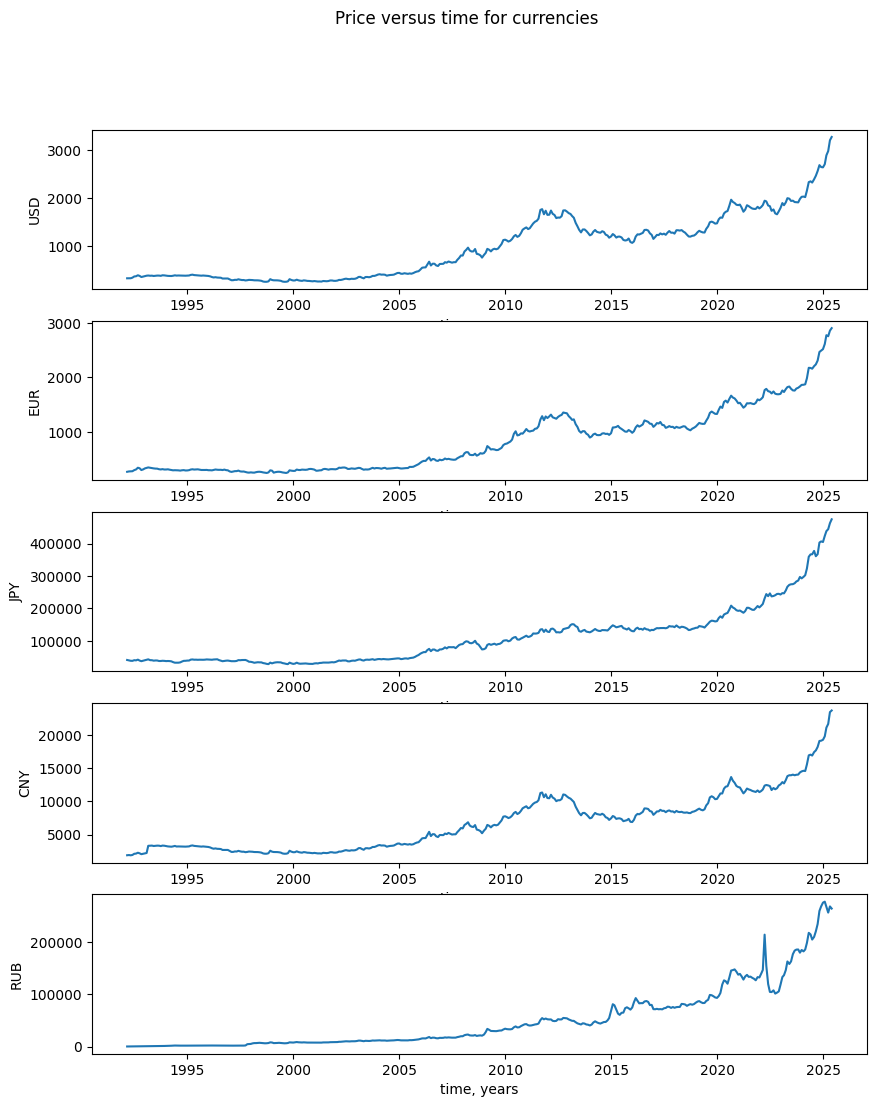

In [6]:
fig, ax = plt.subplots(nrows=5, figsize=(10, 12))
fig.suptitle("Price versus time for currencies")

for idx, currency in enumerate(currencies):
    ax[idx].plot(dataset_gold['Date'], dataset_gold[currency])
    ax[idx].xaxis.set_major_locator(YearLocator(5))
    ax[idx].set_ylabel(currency)
    ax[idx].set_xlabel(f'time, years')

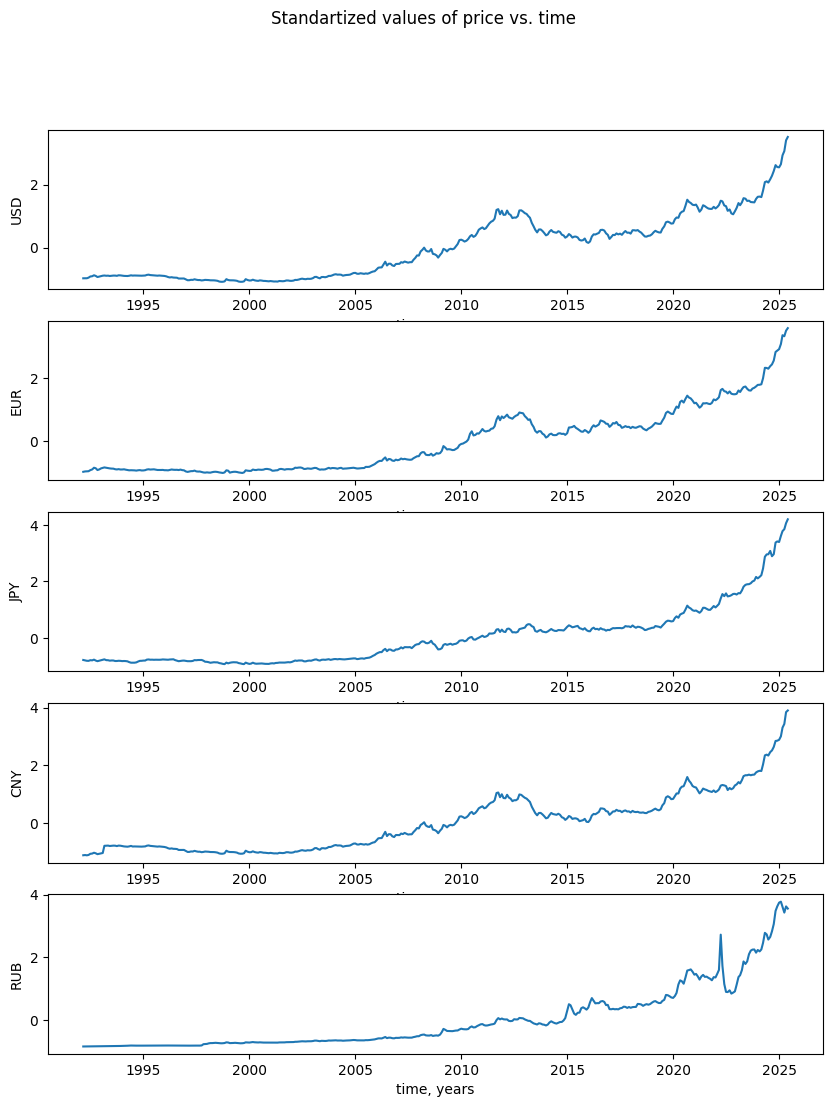

In [7]:
fig, ax = plt.subplots(nrows=5, figsize=(10, 12))
fig.suptitle("Standartized values of price vs. time")

for idx, currency in enumerate(currencies):
    ax[idx].plot(dataset_gold['Date'], (dataset_gold[currency] - dataset_gold[currency].mean()) / dataset_gold[currency].std())
    ax[idx].xaxis.set_major_locator(YearLocator(5))
    ax[idx].set_ylabel(currency)
    ax[idx].set_xlabel(f'time, years')

## TODO
Distribution assumptions

Statistical models for volatility analysis

In [8]:
usd_k = np.fft.fft(dataset_gold['USD'])

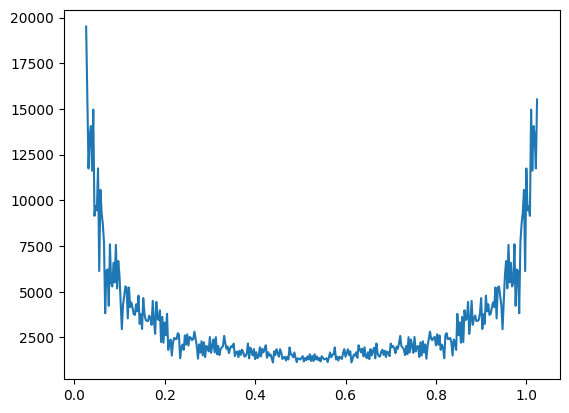

In [9]:
plt.plot(np.arange(10, 390, 1) / 380, np.abs(usd_k[10:-10]))

## Time Series Properties of Datasets

### Time Series Decomposition
#### Gold Dataset

##### Baseline Model
To get started with time series, create a baseline model for predicting the prices for a currency. The results would suggest the needs for optimizations if the model overfits or underfits, such as regularization, filtration, and increasing complexity.

##### Time Series Regression Representation
Due to the sequential manner of such series, the regression task is to extrapolate the functional dependency between time and target. For simplicity of primal analysis, assume the target is fully dependent on the previous observations only. To create features of the new dataset, decompose dataset into a set of vectors, each containing $h$ successive observations. Then, train the model on the dataset, and evaluate on unseen data by composing features in the same manner.

In [10]:
def decompose_data(data: np.array, h: int) -> Tuple[np.array, np.array]:
    """
    Compose features from successive dataset objects using sliding window.

    For example, [y_1, y_2, y_3, y_4, ...] (h=2) would produce

        ([ [y_1, y_2], [y_2, y_3], ...], [y_3, y_4, ...]).

    Parameters:
        data (np.array): 1D-array of target observations.
        h (int): sliding window size.

    Returns:
        Tuple[np.array, np.array]: tuple of sampled dataset of h features
        and the target value for them.
    """
    X = sliding_window_view(data, window_shape=h)[:-1, :]
    X = np.concatenate((X, np.ones(shape=(len(X), 1))), axis=1)
    y = data[h:]
    return (X, y)

In [11]:
train_set, test_set = dataset_gold[dataset_gold['Date'] < '2022-01-01'], dataset_gold[dataset_gold['Date'] >= '2022-01-01']

In [12]:
K = 10
Q_mse = 0
Q_mape = 0
for k in range(K):
    year = 2010 + k
    train_portion, validation_portion = train_set[train_set['Date'] < f'{year}-01-01'], train_set[train_set['Date'] >= f'{year}-01-01']
    
    X_train, y_train = decompose_data(train_portion['USD'], h=11)
    
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)

    X_test, y_test = decompose_data(validation_portion['USD'], h=11)

    y_pred = linear_regressor.predict(X_test)
    Q_mse += mean_squared_error(y_test, y_pred)
    Q_mape += mean_absolute_percentage_error(y_test, y_pred)
Q_mse /= K
Q_mape /= K

In [13]:
print(f"MSE: {Q_mse}, MAPE: {Q_mape}")

MSE: 2711.4585722396096, MAPE: 0.02767418116705912


In [14]:
X_train, y_train = decompose_data(train_set['USD'], h=11)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

X_test, y_test = decompose_data(test_set['USD'], h=11)

y_pred = linear_regressor.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred)}, MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

MSE: 5835.235786833927, MAPE: 0.02570178875067808


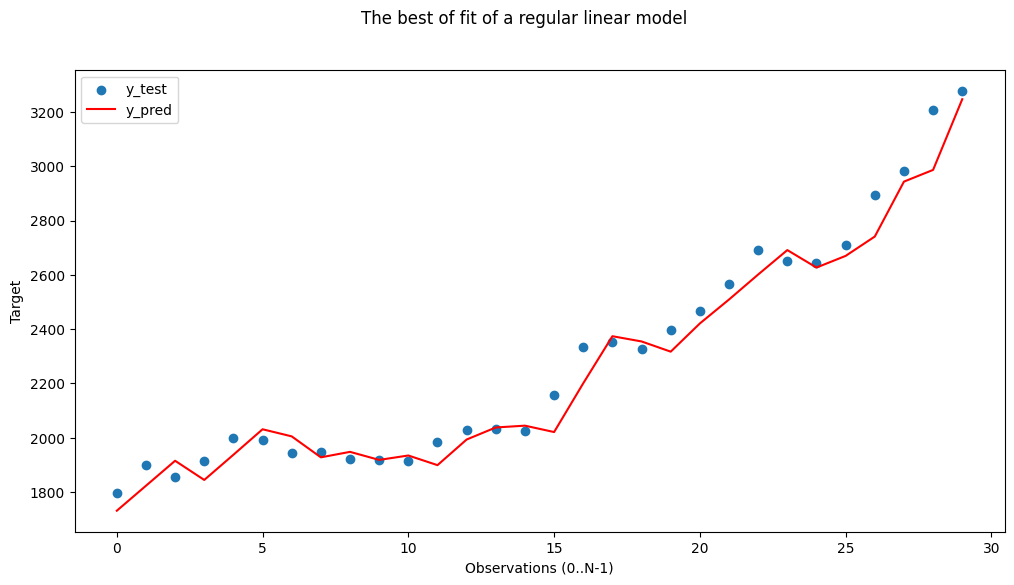

In [15]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
fig.suptitle("The best of fit of a regular linear model")

ax.scatter(np.arange(0, len(y_test)), y_test, label='y_test')
ax.plot(np.arange(0, len(y_test)), y_pred, color='red', label='y_pred')
ax.set_xlabel("Observations (0..N-1)")
ax.set_ylabel('Target')
ax.legend()

##### Basic Filtration

The observed behavior of the model seems promising, although the MSE is still large. Consider the simplest data smoothing filter, called _moving average_. The key idea behind such smoothing technique is to average function over intervals of fixed length. Each interval is comprised of a sliding window moving one step at a time.

In [16]:
def moving_average(period: pd.Series, data: np.array, h: int) -> pd.DataFrame:
    """
    Applies MA filter for the dataset based on the window length.

    Parameters:
        period (pd.Series): the time stamps of the data points.
        data (np.array): the data points.
        h (int): sliding window size.

    Returns:
        pd.DataFrame: the filtered dataset.
    """
    trend = np.sum(sliding_window_view(data, window_shape=h), axis=1) / h
    new_period = period[h//2+1:period.size-h//2+1].reset_index(drop=True)

    dataset_smoothed = pd.DataFrame()
    dataset_smoothed['Date'] = new_period
    dataset_smoothed['USD'] = trend
    return dataset_smoothed

In [17]:
dataset_smoothed = moving_average(dataset_gold['Date'], dataset_gold['USD'], h=11)

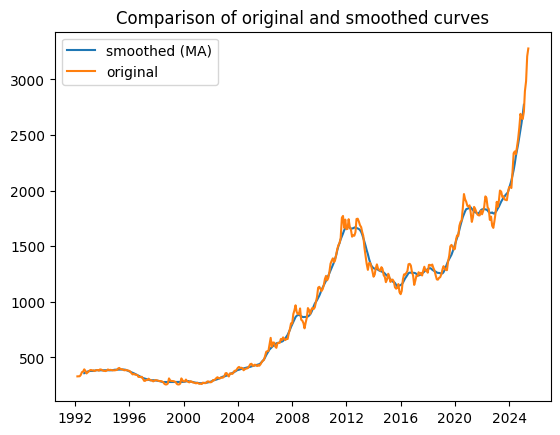

In [18]:
plt.plot(dataset_smoothed['Date'], dataset_smoothed['USD'], label="smoothed (MA)")
plt.plot(dataset_gold['Date'], dataset_gold['USD'], label="original")
plt.title("Comparison of original and smoothed curves")
plt.legend()

In [19]:
train_set, test_set = dataset_smoothed[dataset_smoothed['Date'] < '2022-01-01'], dataset_smoothed[dataset_smoothed['Date'] >= '2022-01-01']

In [20]:
K = 10
Q_mse = 0
Q_mape = 0
for k in range(K):
    year = 2010 + k
    train_portion, validation_portion = train_set[train_set['Date'] < f'{year}-01-01'], train_set[train_set['Date'] >= f'{year}-01-01']
    
    X_train, y_train = decompose_data(train_portion['USD'], h=11)
    
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)

    X_test, y_test = decompose_data(validation_portion['USD'], h=11)

    y_pred = linear_regressor.predict(X_test)
    Q_mse += mean_squared_error(y_test, y_pred)
    Q_mape += mean_absolute_percentage_error(y_test, y_pred)
Q_mse /= K
Q_mape /= K

In [21]:
print(f"MSE: {Q_mse}, MAPE: {Q_mape}")

MSE: 44.6483589890047, MAPE: 0.003605736677367196


In [22]:
X_train, y_train = decompose_data(train_set['USD'], h=11)

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

X_test, y_test = decompose_data(test_set['USD'], h=11)

y_pred = linear_regressor.predict(X_test)

print(f"MSE: {mean_squared_error(y_test, y_pred)}, MAPE: {mean_absolute_percentage_error(y_test, y_pred)}")

MSE: 73.07752813670774, MAPE: 0.0031220693633076746


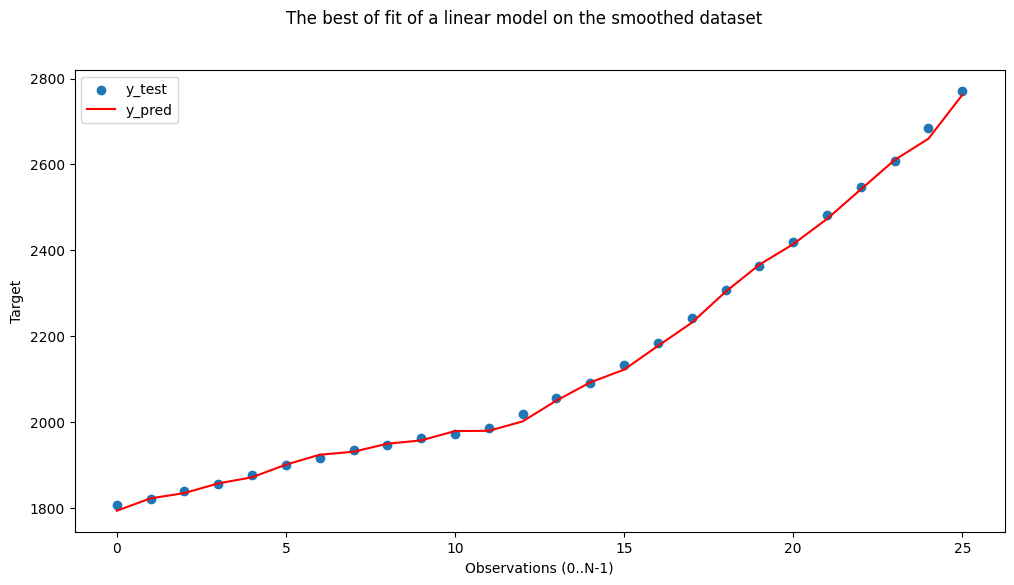

In [23]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 6))
fig.suptitle("The best of fit of a linear model on the smoothed dataset")

ax.scatter(np.arange(0, len(y_test)), y_test, label='y_test')
ax.plot(np.arange(0, len(y_test)), y_pred, color='red', label='y_pred')
ax.set_xlabel("Observations (0..N-1)")
ax.set_ylabel('Target')
ax.legend()